# Animal Classification

## Description
This is notebook to build CNN for animal classification. The intention is use this RNN to classify image to identify what kind of animal in the image. Our aim is get classification model with the most accuracy possible.

I want to build milti class image classification model. So, I think animal classification is the problem that suit this and also interesting. 

## Data Overview

source : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

data type : JPEG images (26,190 images)

data size : 667.9 MB

Size of each image are varies.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    'animal/raw-img',
    label_mode='categorical',
    seed=1992,
    validation_split=0.2,
    subset = 'both',
    batch_size=32,
    image_size=(128, 128)
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Using 5235 files for validation.


We have 26179 images belonging to 10 classes.

In [3]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Class names are italian. But it's not a problem.

In [149]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}

In [5]:
# function to get english class name
def get_class_name(label):
    return translate[class_names[np.where(label == 1)[0][0]]]

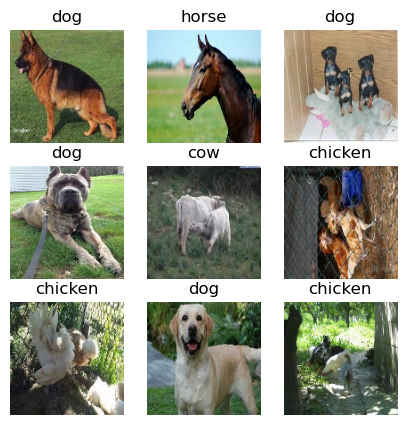

In [6]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(labels[i]))
    plt.axis("off")

In [7]:
# count each class in training set
all_labels = []
for batch in train_ds:
    for l in batch[1].numpy():
        all_labels.append(get_class_name(l))

train_label_count = Counter(all_labels)

In [8]:
# count each class in test set
all_labels = []
for batch in test_ds:
    for l in batch[1].numpy():
        all_labels.append(get_class_name(l))

test_label_count = Counter(all_labels)

<Axes: xlabel='class', ylabel='count'>

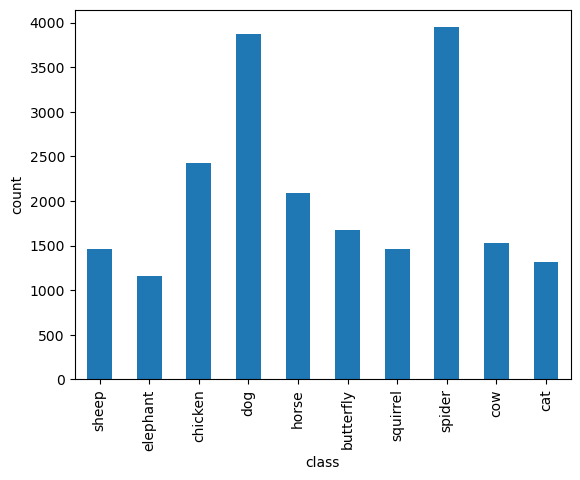

In [9]:
# plot bar chart for classes in traning data
train_label_count_df = pd.DataFrame.from_dict(train_label_count, orient='index').reset_index()
train_label_count_df.plot.bar(x='index', y=0, xlabel='class', ylabel='count', legend=False)

<Axes: xlabel='class', ylabel='count'>

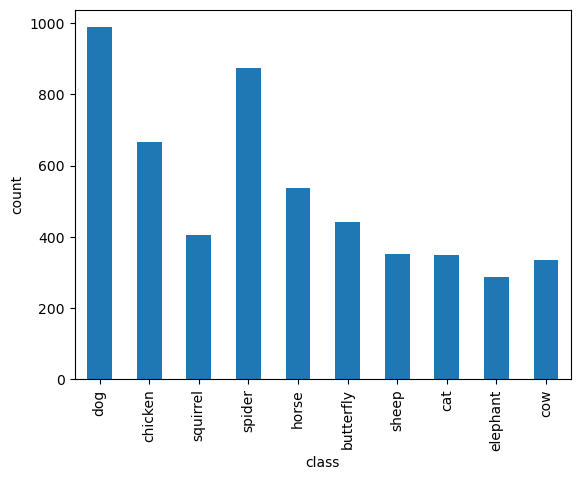

In [10]:
# plot bar chart for classes in test data
test_label_count_df = pd.DataFrame.from_dict(test_label_count, orient='index').reset_index()
test_label_count_df.plot.bar(x='index', y=0, xlabel='class', ylabel='count', legend=False)

From charts above, we have lot of spider and dog images in both training and test data. The fewset images we have are elephant images.

### Analysis
Since we have lot of dog and spider images, classify dog and spider should have higest accuracy among all classes. Otherwise classify elephant images may be issue because we have fewset of elephant images. Size of each image are varies. So, we need to resize them to be the same before feed to the model (which is 128x128px). Sample images look fine. Therefore, I don't think clean up was necessary.

## Classification
First, I will try with simple CNN model as based line. Then, try again with more complex model. Also, I would use hyper parameter technique to improve accuracy.

In [11]:
# build base model
model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(10, activation='softmax'),
])

In [12]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1

In [2]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [14]:
epochs= 10
%time history = model1.fit(train_ds, batch_size=32, validation_data=test_ds, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 19s 27ms/step - loss: 0.0896 - accuracy: 0.2288 - val_loss: 0.0834 - val_accuracy: 0.3131
Epoch 2/10
655/655 [==============================] - 18s 27ms/step - loss: 0.0867 - accuracy: 0.2956 - val_loss: 0.0832 - val_accuracy: 0.3234
Epoch 3/10
655/655 [==============================] - 18s 27ms/step - loss: 0.0825 - accuracy: 0.3730 - val_loss: 0.0871 - val_accuracy: 0.3610
Epoch 4/10
655/655 [==============================] - 18s 27ms/step - loss: 0.0896 - accuracy: 0.3912 - val_loss: 0.1795 - val_accuracy: 0.1026
Epoch 5/10
655/655 [==============================] - 18s 27ms/step - loss: 0.1768 - accuracy: 0.1155 - val_loss: 0.1745 - val_accuracy: 0.1276
Epoch 6/10
655/655 [==============================] - 21s 32ms/step - loss: 0.1767 - accuracy: 0.1166 - val_loss: 0.1745 - val_accuracy: 0.1276
Epoch 7/10
655/655 [==============================] - 23s 35ms/step - loss: 0.1749 - accuracy: 0.1253 - val_loss: 0.1814 - val_accuracy:

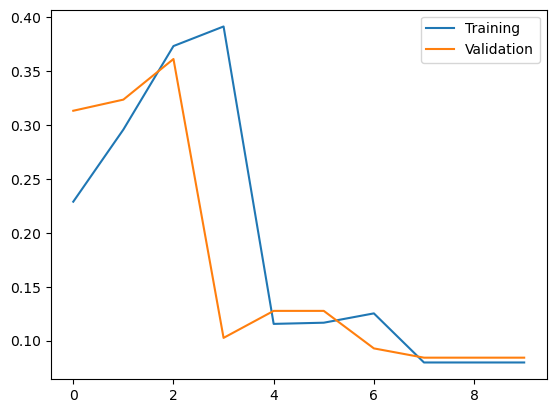

In [15]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This base model looks quite bad. It's actually worst than average guess. So, I will add more complexity which should improve performance. 

In [38]:
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [39]:
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 256)      

In [40]:
epochs= 10
%time history = model2.fit(train_ds, batch_size=32, validation_data=test_ds, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 148s 225ms/step - loss: 2.3725 - accuracy: 0.2581 - val_loss: 4.2748 - val_accuracy: 0.1952
Epoch 2/10
655/655 [==============================] - 111s 170ms/step - loss: 3.6800 - accuracy: 0.2408 - val_loss: 3.1539 - val_accuracy: 0.2279
Epoch 3/10
655/655 [==============================] - 114s 174ms/step - loss: 8.1468 - accuracy: 0.2177 - val_loss: 13.1097 - val_accuracy: 0.2648
Epoch 4/10
655/655 [==============================] - 113s 172ms/step - loss: 37.3147 - accuracy: 0.2410 - val_loss: 39.9428 - val_accuracy: 0.2424
Epoch 5/10
655/655 [==============================] - 112s 172ms/step - loss: 82.8619 - accuracy: 0.2528 - val_loss: 1506.6877 - val_accuracy: 0.0735
Epoch 6/10
655/655 [==============================] - 122s 186ms/step - loss: 734.8806 - accuracy: 0.1864 - val_loss: 118.1494 - val_accuracy: 0.2229
Epoch 7/10
655/655 [==============================] - 117s 179ms/step - loss: 544.5635 - accuracy: 0.1969 - val_l

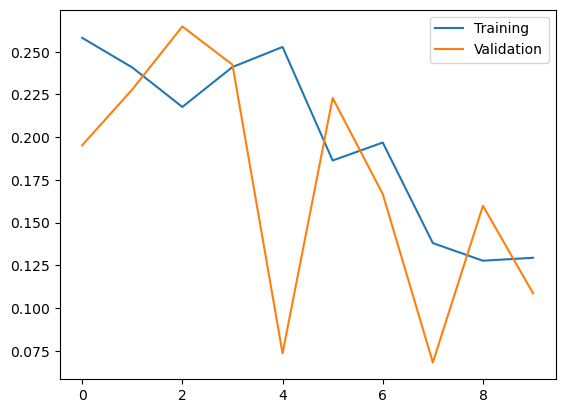

In [42]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

Accuracy going up which migth cause by learning rate too high. So, I will reduce learning and some parameter tuning.

In [7]:
model3 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [8]:
model3.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 256)      

In [9]:
train_ds_2048, test_ds_2048 = tf.keras.utils.image_dataset_from_directory(
    'animal/raw-img',
    label_mode='categorical',
    seed=1992,
    validation_split=0.2,
    subset = 'both',
    batch_size=32,
    image_size=(128, 128)
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Using 5235 files for validation.


In [10]:
epochs= 10

%time history = model3.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 111s 168ms/step - loss: 1.9762 - accuracy: 0.3079 - val_loss: 1.7921 - val_accuracy: 0.3788
Epoch 2/10
655/655 [==============================] - 111s 170ms/step - loss: 1.6587 - accuracy: 0.4297 - val_loss: 1.6446 - val_accuracy: 0.4384
Epoch 3/10
655/655 [==============================] - 113s 172ms/step - loss: 1.5378 - accuracy: 0.4759 - val_loss: 1.5586 - val_accuracy: 0.4728
Epoch 4/10
655/655 [==============================] - 118s 180ms/step - loss: 1.4643 - accuracy: 0.5015 - val_loss: 1.5194 - val_accuracy: 0.4856
Epoch 5/10
655/655 [==============================] - 116s 176ms/step - loss: 1.4257 - accuracy: 0.5177 - val_loss: 1.5352 - val_accuracy: 0.4827
Epoch 6/10
655/655 [==============================] - 128s 196ms/step - loss: 1.4035 - accuracy: 0.5272 - val_loss: 1.5356 - val_accuracy: 0.4831
Epoch 7/10
655/655 [==============================] - 127s 193ms/step - loss: 1.4107 - accuracy: 0.5226 - val_loss: 1.6527 -

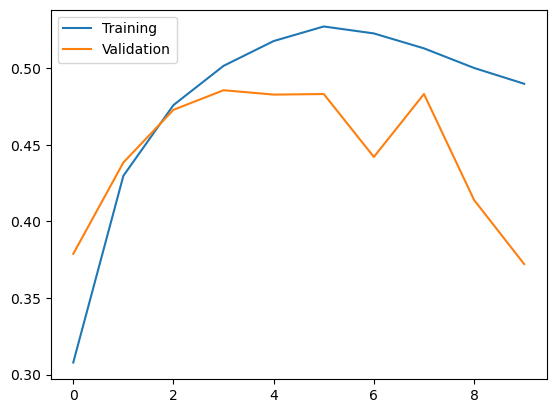

In [11]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

I also chage batch size for this model and it a lot better. I can see some overfitted issue. I will add more complexity to increase accuracy. We will look at overfitted issue later.

In [50]:
model4 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [51]:
model4.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_85 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 28, 28, 256)     

In [53]:
epochs= 10

%time history = model4.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 124s 188ms/step - loss: 1.9611 - accuracy: 0.3167 - val_loss: 1.7576 - val_accuracy: 0.4013
Epoch 2/10
655/655 [==============================] - 126s 192ms/step - loss: 1.6321 - accuracy: 0.4454 - val_loss: 1.5937 - val_accuracy: 0.4569
Epoch 3/10
655/655 [==============================] - 133s 203ms/step - loss: 1.5155 - accuracy: 0.4840 - val_loss: 1.5258 - val_accuracy: 0.4844
Epoch 4/10
655/655 [==============================] - 130s 198ms/step - loss: 1.4404 - accuracy: 0.5116 - val_loss: 1.4738 - val_accuracy: 0.4984
Epoch 5/10
655/655 [==============================] - 142s 217ms/step - loss: 1.4063 - accuracy: 0.5251 - val_loss: 1.5309 - val_accuracy: 0.4770
Epoch 6/10
655/655 [==============================] - 148s 226ms/step - loss: 1.3974 - accuracy: 0.5257 - val_loss: 1.5428 - val_accuracy: 0.4856
Epoch 7/10
655/655 [==============================] - 141s 215ms/step - loss: 1.4137 - accuracy: 0.5274 - val_loss: 1.5894 -

I felt that the learning rate is too high. Because loss increase after epoch 7 . So, I will reduce learning rate.

In [75]:
model5 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [76]:
model5.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_24 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_109 (Conv2D)         (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_111 (Conv2D)         (None, 28, 28, 256)     

In [77]:
epochs= 10

%time history = model5.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 112s 170ms/step - loss: 2.1913 - accuracy: 0.2140 - val_loss: 2.1578 - val_accuracy: 0.2363
Epoch 2/10
655/655 [==============================] - 131s 200ms/step - loss: 2.0979 - accuracy: 0.2726 - val_loss: 2.0562 - val_accuracy: 0.3011
Epoch 3/10
655/655 [==============================] - 133s 202ms/step - loss: 1.9949 - accuracy: 0.3236 - val_loss: 1.9656 - val_accuracy: 0.3276
Epoch 4/10
655/655 [==============================] - 121s 184ms/step - loss: 1.9046 - accuracy: 0.3563 - val_loss: 1.8911 - val_accuracy: 0.3557
Epoch 5/10
655/655 [==============================] - 119s 181ms/step - loss: 1.8332 - accuracy: 0.3825 - val_loss: 1.8356 - val_accuracy: 0.3725
Epoch 6/10
655/655 [==============================] - 129s 197ms/step - loss: 1.7777 - accuracy: 0.4014 - val_loss: 1.7951 - val_accuracy: 0.3885
Epoch 7/10
655/655 [==============================] - 129s 196ms/step - loss: 1.7340 - accuracy: 0.4169 - val_loss: 1.7606 -

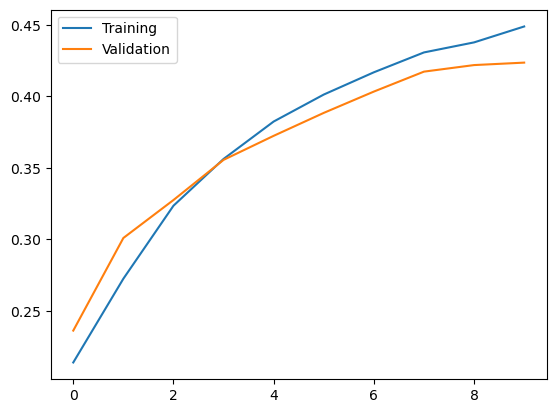

In [78]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

I think I reduce learning rate too much (it's too slow). So, I will increase a bit.

In [81]:
# save model5. We might comeback to this later
checkpoint_filepath = "./checkpoint_animal_model5"
tf.keras.saving.save_model(model5, checkpoint_filepath, overwrite=True)

INFO:tensorflow:Assets written to: ./checkpoint_animal_model5/assets


INFO:tensorflow:Assets written to: ./checkpoint_animal_model5/assets


In [83]:
model6 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [84]:
model6.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
epochs= 10

%time history = model6.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 114s 173ms/step - loss: 2.1188 - accuracy: 0.2527 - val_loss: 2.0077 - val_accuracy: 0.3188
Epoch 2/10
655/655 [==============================] - 112s 172ms/step - loss: 1.8751 - accuracy: 0.3603 - val_loss: 1.8259 - val_accuracy: 0.3687
Epoch 3/10
655/655 [==============================] - 119s 182ms/step - loss: 1.7235 - accuracy: 0.4167 - val_loss: 1.7229 - val_accuracy: 0.4206
Epoch 4/10
655/655 [==============================] - 129s 197ms/step - loss: 1.6384 - accuracy: 0.4453 - val_loss: 1.6590 - val_accuracy: 0.4361
Epoch 5/10
655/655 [==============================] - 127s 194ms/step - loss: 1.5802 - accuracy: 0.4654 - val_loss: 1.6130 - val_accuracy: 0.4548
Epoch 6/10
655/655 [==============================] - 115s 175ms/step - loss: 1.5371 - accuracy: 0.4826 - val_loss: 1.5786 - val_accuracy: 0.4646
Epoch 7/10
655/655 [==============================] - 121s 184ms/step - loss: 1.5014 - accuracy: 0.4928 - val_loss: 1.5561 -

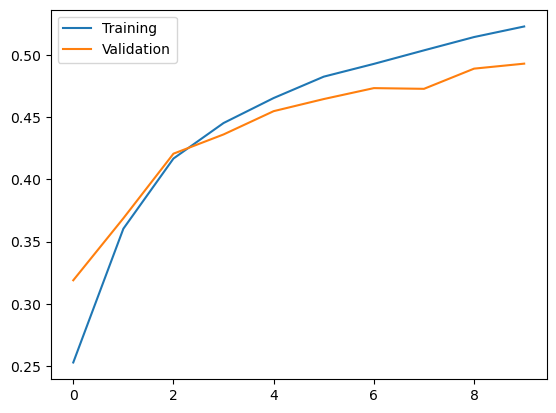

In [86]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

This model seems good. I will run this model more 10 epochs.

In [87]:
epochs = 10

%time history = model6.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/10
655/655 [==============================] - 135s 206ms/step - loss: 1.3904 - accuracy: 0.5330 - val_loss: 1.4900 - val_accuracy: 0.4909
Epoch 2/10
655/655 [==============================] - 138s 210ms/step - loss: 1.3705 - accuracy: 0.5398 - val_loss: 1.4685 - val_accuracy: 0.4955
Epoch 3/10
655/655 [==============================] - 128s 195ms/step - loss: 1.3517 - accuracy: 0.5453 - val_loss: 1.4603 - val_accuracy: 0.5032
Epoch 4/10
655/655 [==============================] - 112s 171ms/step - loss: 1.3347 - accuracy: 0.5543 - val_loss: 1.4469 - val_accuracy: 0.5140
Epoch 5/10
655/655 [==============================] - 124s 189ms/step - loss: 1.3213 - accuracy: 0.5593 - val_loss: 1.4310 - val_accuracy: 0.5112
Epoch 6/10
655/655 [==============================] - 133s 203ms/step - loss: 1.3076 - accuracy: 0.5645 - val_loss: 1.4432 - val_accuracy: 0.5072
Epoch 7/10
655/655 [==============================] - 133s 203ms/step - loss: 1.2957 - accuracy: 0.5691 - val_loss: 1.4222 -

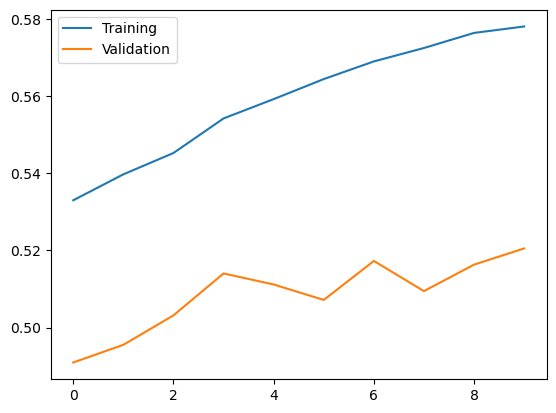

In [88]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

I think this model have right learning rate, but It's overffited. We can see that training accuuracy increase but test accuuracy is not increase. So, I will try to add dropout and this is our last model.

In [98]:
# save model6. We might comeback to this later
checkpoint_filepath = "./checkpoint_animal_model6"
tf.keras.saving.save_model(model6, checkpoint_filepath, overwrite=True)

INFO:tensorflow:Assets written to: ./checkpoint_animal_model6/assets


INFO:tensorflow:Assets written to: ./checkpoint_animal_model6/assets


In [93]:
model7 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='sigmoid'),
])

In [94]:
model7.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
epochs= 20

%time history = model7.fit(train_ds_2048, batch_size=2048, validation_data=test_ds_2048, epochs=epochs)

Epoch 1/20
655/655 [==============================] - 143s 217ms/step - loss: 2.1696 - accuracy: 0.2151 - val_loss: 2.1479 - val_accuracy: 0.1849
Epoch 2/20
655/655 [==============================] - 120s 182ms/step - loss: 2.0041 - accuracy: 0.2944 - val_loss: 2.0212 - val_accuracy: 0.2418
Epoch 3/20
655/655 [==============================] - 122s 187ms/step - loss: 1.8443 - accuracy: 0.3575 - val_loss: 1.9151 - val_accuracy: 0.3051
Epoch 4/20
655/655 [==============================] - 127s 194ms/step - loss: 1.7548 - accuracy: 0.3913 - val_loss: 1.8507 - val_accuracy: 0.3362
Epoch 5/20
655/655 [==============================] - 131s 200ms/step - loss: 1.6951 - accuracy: 0.4153 - val_loss: 1.8701 - val_accuracy: 0.3393
Epoch 6/20
655/655 [==============================] - 126s 193ms/step - loss: 1.6524 - accuracy: 0.4356 - val_loss: 1.8103 - val_accuracy: 0.3616
Epoch 7/20
655/655 [==============================] - 124s 189ms/step - loss: 1.6159 - accuracy: 0.4496 - val_loss: 1.8221 -

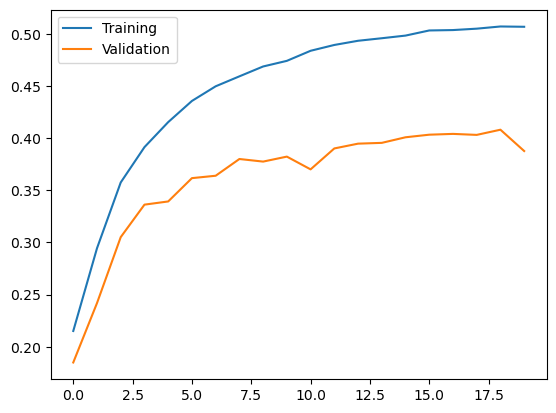

In [96]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show()

Add dropout reduce accuracy for both training accuracy and test accuracy. May be reduce dropout might help, but I would stop it here.

I will do some result analysis from our best model (model6).

In [123]:
# get perdict result
yh = model6.predict(test_ds_2048, batch_size=2048)

164/164 [==============================] - 7s 40ms/step


In [124]:
# convert to number for confusion matrix
y_pred = []
for y in yh:
    y_pred.append(np.array(y).argmax())

In [125]:
# convert to number for confusion matrix
y_true = []
for batch in test_ds_2048:
    for l in batch[1].numpy():
        y_true.append(np.where(l == 1)[0][0])

In [126]:
sklearn.metrics.accuracy_score(y_true, y_pred)

0.5207258834765998

In [130]:
# confusion matrix for test data
from sklearn.metrics import confusion_matrix

con_mat = confusion_matrix(y_true, y_pred)

con_mat

array([[698,  40,  17,  11,  20,  31,  71,  21,  47,  32],
       [ 96, 259,  13,   5,  16,   5, 103,  14,  19,   7],
       [ 59,  35,  88,   2,  17,   0,  33,  15,  14,  24],
       [ 21,   3,   3, 267,  23,  14,   5,   5,  86,  14],
       [146,  22,  18,  24, 306,   6,  27,  29,  43,  46],
       [150,   6,   3,  12,  24,  66,   8,   4,  62,  15],
       [ 66,  56,  13,   1,   8,   1, 150,  23,   7,  10],
       [ 54,  10,  18,   3,  16,   3,  57, 151,  22,  19],
       [ 66,  10,  11,  63,  40,  18,   7,  15, 615,  28],
       [134,  10,   4,  10,  40,  18,  17,  11,  34, 126]])

Virtualize confusion matrix with heat map.

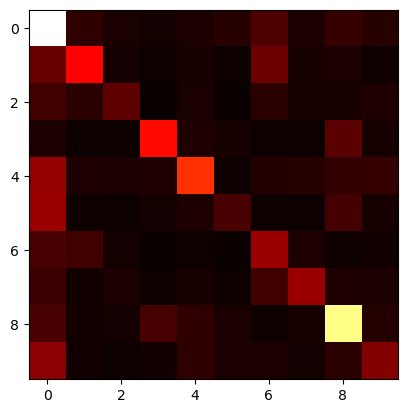

In [158]:
plt.imshow(con_mat, cmap='hot', interpolation='nearest')
plt.show()

In [139]:
# find all true positive
tp = []
for i in range(10):
    tp.append(con_mat[i][i])
tp

[698, 259, 88, 267, 306, 66, 150, 151, 615, 126]

In [142]:
pos = []
for i in range(10):
    pos.append(sum(con_mat[i]))
pos

[988, 537, 287, 441, 667, 350, 335, 353, 873, 404]

In [160]:
tpp = []
tss = []
for i in range(10):
    tss.append(translate[test_ds_2048.class_names[i]])
    tpp.append(100.0*tp[i]/pos[i])
tppz = dict(zip(tss,tpp))

<Axes: xlabel='class', ylabel='correct percent'>

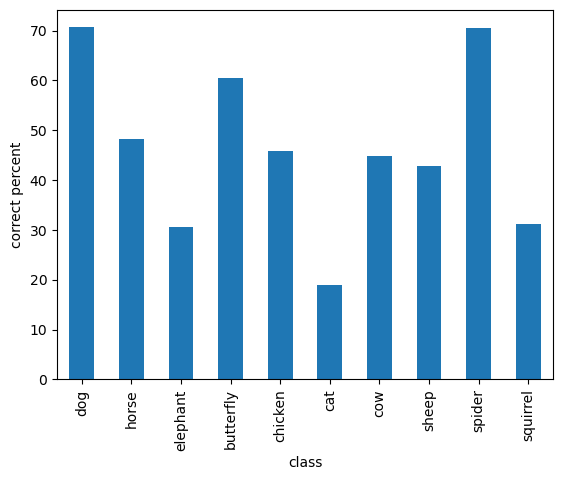

In [161]:
tppz_df = pd.DataFrame.from_dict(tppz, orient='index').reset_index()
tppz_df.plot.bar(x='index', y=0, xlabel='class', ylabel='correct percent', legend=False)

From bar chart above. Dog and spider have highest accuracy as expected. But, lowest is cat not elephent which we have lowest training data.

From confusion matrix, a lot of cat images miss classify as dog which might come from the fact that dog and cat are similar and data imbalance (we have about 4,000 images of dogs and about 1,500 cat images).

## Conclusion
First, we explore data. Then, we did some analysis from what we observe. After that, we build models and improve it by tuning hyper-parameter and change architecture. We got best model with accuracy on test data = 0.52. Which I think not that bad for 10 classes classification. During improving model accuracy we faced issues which are learning rate not right and overfitted. And we did solved only learning rate issue. I think there are a lot of improve to the model. I think if we alter training data to balance data between classes, the model might have higher accuracy.

## References
https://www.tensorflow.org/tutorials/images/classification

GitHub : https://github.com/Satjarporn/animal